In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['train', 'test']
['horse', 'cat', 'bird', 'ship', 'dog', 'airplane', 'deer', 'truck', 'automobile', 'frog']


In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

#adjusting training image values to make sure our model doesnt overfit to the training data
train_tfms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)
                         ])

val_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds= ImageFolder(data_dir + '/train',train_tfms)

val_ds = ImageFolder(data_dir + '/test',val_tfms)

In [ ]:
(train_ds.classes,val_ds.classes)

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [ ]:
batch_size = 400

In [ ]:
(len(train_ds),len(val_ds))

(50000, 10000)

In [ ]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
val_dl = DataLoader(val_ds,2*batch_size,num_workers=3,pin_memory=True)

In [ ]:
def denormalize(images,means,stds):
  mean = torch.tensor(means).reshape(1,3,1,1)
  stds= torch.tensor(stds).reshape(1,3,1,1)
  return images * stds + mean

In [ ]:
def show_batch(dl):
  for images,labels in dl:
    fig,ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_img = denormalize(images,*stats)
    ax.imshow(make_grid(denorm_img[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

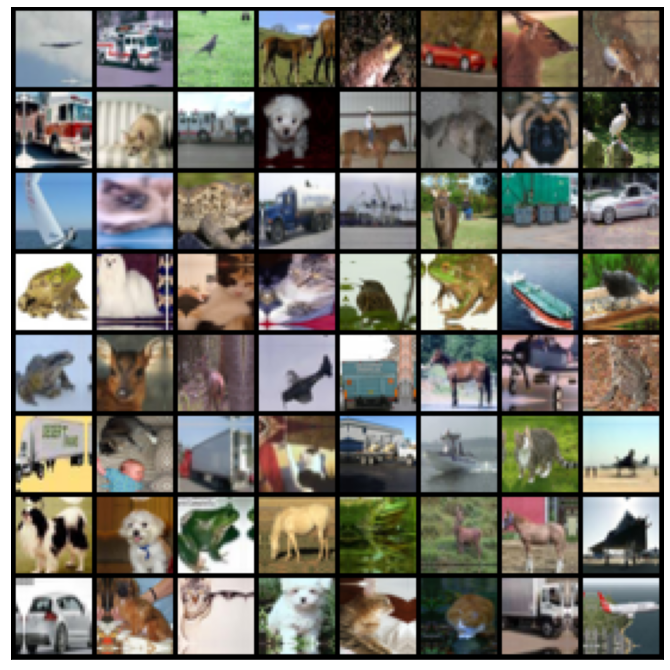

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():

  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
def to_device(data,device):
  
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  
  return data.to(device,non_blocking=True)

In [ ]:
class DeviceDataLoader():

  def __init__(self,dl,device):
    self.dl= dl
    self.device = device

  def __iter__(self):

    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):

    return len(self.dl)

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
train_dl= DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [ ]:
def accuracy(outputs,labels):
  _,preds = torch.max(outputs,dim=1)

  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels,out_channels,pool=False):
  layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  
  return nn.Sequential(*layers)

In [ ]:
class ResNet9(ImageClassBase):

  def __init__(self,in_channels,num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels,64)
    self.conv2 = conv_block(64,128,pool=True)
    self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))

    self.conv3 = conv_block(128,256,pool=True)
    self.conv4 = conv_block(256,512,pool=True)
    self.res2  = nn.Sequential(conv_block(512,512),conv_block(512,512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4), # dimentions = 512 x 1 x 1
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512,num_classes)) # 10 outputs
    
  def forward(self,xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)

    return out


In [ ]:
model = to_device(ResNet9(3,10),device)

In [ ]:
model #model structure

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

    

In [ ]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model,val_dl)]

In [ ]:
history

[{'val_acc': tensor(0.5819), 'val_loss': tensor(1.2126, device='cuda:0')}]

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay)

Epoch [0], last_lr: 0.00393, train_loss: 0.9609, val_loss: 1.2825, val_acc: 0.5809
Epoch [1], last_lr: 0.00935, train_loss: 0.9450, val_loss: 1.3173, val_acc: 0.5799
Epoch [2], last_lr: 0.00972, train_loss: 0.8035, val_loss: 0.8606, val_acc: 0.7017
Epoch [3], last_lr: 0.00812, train_loss: 0.6428, val_loss: 0.6611, val_acc: 0.7707
Epoch [4], last_lr: 0.00556, train_loss: 0.5118, val_loss: 0.5282, val_acc: 0.8188
Epoch [5], last_lr: 0.00283, train_loss: 0.4209, val_loss: 0.4340, val_acc: 0.8561
Epoch [6], last_lr: 0.00077, train_loss: 0.3089, val_loss: 0.3053, val_acc: 0.8978
Epoch [7], last_lr: 0.00000, train_loss: 0.2225, val_loss: 0.2835, val_acc: 0.9068


In [ ]:
#90% accuracy